# Project: Electric Vehicle Charging Scheduling Problem (EVCS)
## First deliverable
## Prescriptive Analytics: Heuristics for Decision Making
### Wilmar Calderón - 201630701

The Electric Vehicle Charging Scheduling (EVCS) problems aims to determine the optimal sequence of charging $n$ vehicles in $m$ chargers. The EVCS can be formulated with multiple objectives as reducing cost or maximizing the charge, which are the most common objectives for the problem. This implementation describes a constructive Heuristic formulation to obtain an initial and feasible solution for the EVCS. The proposed implementation considers two approaches, first, the Earliest Departure First (EDF) and the First Come First Served (FCFS) approach. the former, prioritizes the vehicles that have the nearest departure time to schedule its charge first, the latter considers that the first vehcile that arrives should be attended. Implementation of the Heuristic is described below.

In [7]:
import json
import pandas as pd
from typing import Dict, Tuple
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time

In [8]:
step=0.25 #Time spacing: Model parameter (value corresponds to fraction of an hour) 5% of 1 hour=3min

def time_to_index(t, delta_t=step):
    return int(t / delta_t)

def available_slots(initial,final):
    return range(initial,final+1)

#JSON File reader
#Input: Filepath
#Output: dict(Pandas Dataframes with the loaded information), int(number of parking spots), int(transformer limit)
def load_json_to_dfs(file_path: str) -> Tuple[Dict[str, pd.DataFrame], int, int]:
    with open(file_path, 'r') as file:
        data = json.load(file)
    dfs = {} #Dictionary where the dataframes will be sotred
    # Extracts the information in the JSON file of the filepath entered as parameter
    parking_config = data.get('parking_config', {})  #info related to the chargers
    n_spot = parking_config['n_spots'] #number of parking spots
    transformer_limit =parking_config['transformer_limit'] #Transformer limit

    dfs['energy_prices'] = pd.DataFrame(data['energy_prices'], columns=['time', 'price']) #Energy price dataframe

    dfs['arrivals'] = pd.DataFrame(data['arrivals'], columns=['id','arrival_time', 'departure_time', 'required_energy','brand','min_charge_rate',
                                                             'max_charge_rate','ac_charge_rate','dc_charge_rate','willingness_to_pay']) #Extraction of details of the attended EV
    dfs["arrivals"]["brand"]= dfs["arrivals"]["brand"].str.rsplit(' ').str[:-1].apply(' '.join)
    dfs["arrivals"]["arrival_slot"]=dfs["arrivals"]["arrival_time"].apply(time_to_index)
    dfs["arrivals"]["departure_slot"]=dfs["arrivals"]["departure_time"].apply(time_to_index)
    dfs["arrivals"]["available_slots"]=dfs["arrivals"].apply(lambda x: available_slots(x["arrival_slot"],x["departure_slot"]),axis=1)
    dfs['chargers'] = pd.DataFrame(parking_config['chargers'],columns=["charger_id","power","type","operation_cost_per_hour","compatible_vehicles"]) #Chargers Dataframe


    return dfs, n_spot, transformer_limit

In [9]:
i=1
filename_exact="EVCP_MILP_instance_"+str(i)+".xlsx"
filename_edf="EVCP_PA-EDF_instance_"+str(i)+".xlsx"
filename_fcfs="EVCP_SA-FCFS_instance_"+str(i)+".xlsx"
filename_ils="EVCP_ILS_instance_"+str(i-1)+".xlsx"
file_path = 'test_system_'+str(i)+'.json'
dfs, n_spot, transformer_limit = load_json_to_dfs(file_path)

df_exact = pd.read_excel(filename_exact)
# Set the time column
df_exact = df_exact.rename(columns={df_exact.columns[0]: "Time"})
# Calculate total power per time step
df_exact["TotalPower"] = df_exact.drop(columns="Time").sum(axis=1)

df_edf = pd.read_excel(filename_edf)
# Set the time column
df_edf = df_edf.rename(columns={df_edf.columns[0]: "Time"})
# Calculate total power per time step
df_edf["TotalPower"] = df_edf.drop(columns="Time").sum(axis=1)

df_fcfs = pd.read_excel(filename_fcfs)
# Set the time column
df_fcfs = df_fcfs.rename(columns={df_fcfs.columns[0]: "Time"})
# Calculate total power per time step
df_fcfs["TotalPower"] = df_fcfs.drop(columns="Time").sum(axis=1)

df_ils = pd.read_excel(filename_ils)
# Set the time column
df_ils = df_ils.rename(columns={df_ils.columns[0]: "Time"})
# Calculate total power per time step
df_ils["TotalPower"] = df_ils.drop(columns="Time").sum(axis=1)

C:\Users\wilma\AppData\Local\Temp\ipykernel_12196\547388815.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  power_per_hour = total_power_per_timestep.groupby(binned).sum()
C:\Users\wilma\AppData\Local\Temp\ipykernel_12196\547388815.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  power_per_hour = total_power_per_timestep1.groupby(binned).sum()


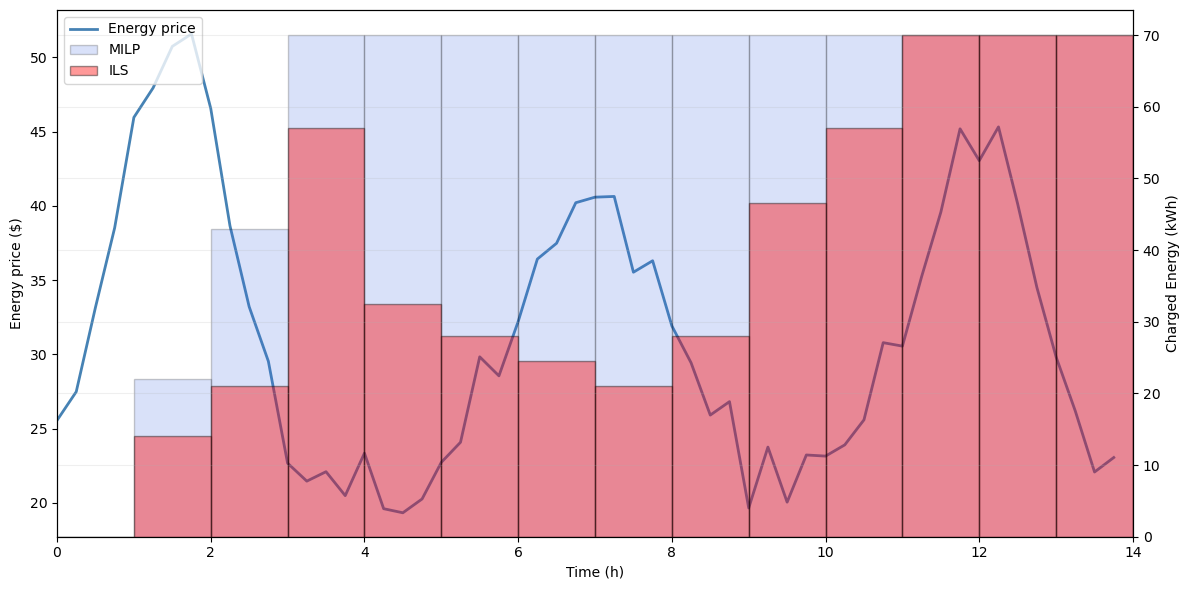

In [15]:
charging_p=df_exact.copy().drop(columns=["Time","TotalPower"])
# Step 1: Make sure your index is float time values
time_index = charging_p.index.astype(float)
# Step 2: Total power across EVs at each timestep
total_power_per_timestep = charging_p.sum(axis=1)
# Step 3: Define hour bins
start = np.floor(time_index.min())
end = np.ceil(time_index.max())
bins = np.arange(start, end + 1, 1.0)

# Step 4: Cut into bins — use integer labels
binned = pd.cut(time_index, bins=bins, labels=bins[:-1].astype(int), right=False)
# Step 5: Group and sum
power_per_hour = total_power_per_timestep.groupby(binned).sum()

# Convert index to float so we can use it in bar plot
x = power_per_hour.index.astype(float)
y = power_per_hour.values/step


charging_p1=df_ils.copy().drop(columns=["Time","TotalPower"])
# Step 1: Make sure your index is float time values
time_index1 = charging_p1.index.astype(float)
# Step 2: Total power across EVs at each timestep
total_power_per_timestep1 = charging_p1.sum(axis=1)
# Step 3: Define hour bins
start = np.floor(time_index1.min())
end = np.ceil(time_index1.max())
bins = np.arange(start, end + 1, 1.0)

# Step 4: Cut into bins — use integer labels
binned = pd.cut(time_index1, bins=bins, labels=bins[:-1].astype(int), right=False)
# Step 5: Group and sum
power_per_hour = total_power_per_timestep1.groupby(binned).sum()

# Convert index to float so we can use it in bar plot
x1 = power_per_hour.index.astype(float)
y1 = power_per_hour.values/step


fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Line (energy price)
line = ax1.plot(
    dfs["energy_prices"]["time"], 
    dfs["energy_prices"]["price"], 
    color="steelblue", 
    linewidth=2, 
    label="Energy price"
)

# Bar (charging energy)
bars = ax2.bar(
    x=x, 
    height=y, 
    width=1.0, 
    align='edge', 
    color='royalblue', 
    edgecolor='black', 
    alpha=0.2, 
    label="MILP"
)

# Bar (charging energy)
bars = ax2.bar(
    x=x1, 
    height=y1, 
    width=1.0, 
    align='edge', 
    color='red', 
    edgecolor='black', 
    alpha=0.4, 
    label="ILS"
)
# Axis labels
ax1.set_xlabel("Time (h)")
ax1.set_xlim([0, 14])
ax1.set_ylabel("Energy price ($)")
ax2.set_ylabel("Charged Energy (kWh)")

# Combine legends from both axes
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1],loc="upper left")
plt.grid(True,alpha=0.2)
plt.tight_layout()
plt.show()

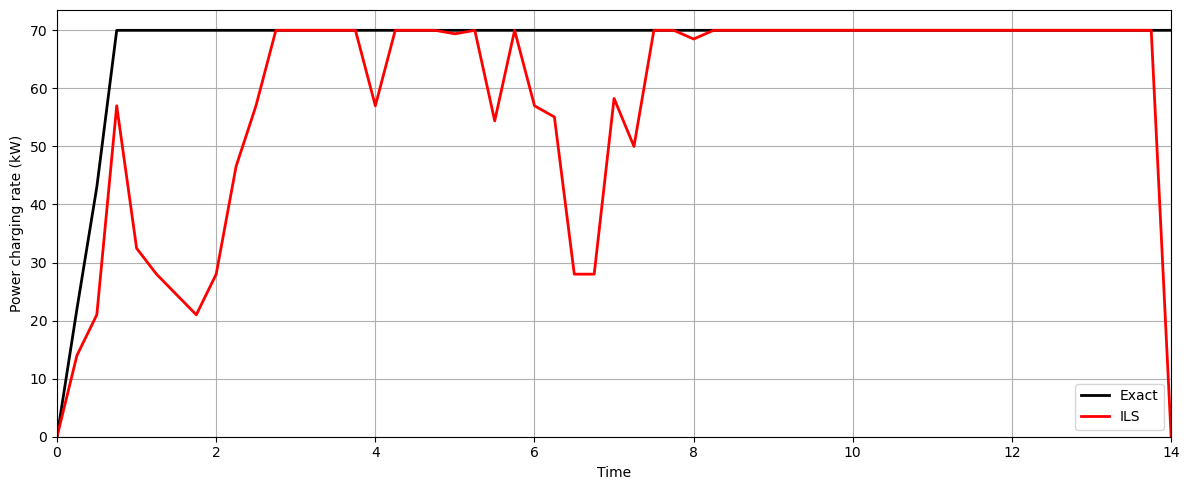

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_exact["Time"], df_exact["TotalPower"]/step, color="black", linewidth=2,label="Exact")
# plt.plot(df_fcfs["Time"], df_fcfs["TotalPower"]/step, color="black",linewidth=2,label="FCFS")
# plt.plot(df_edf["Time"], df_edf["TotalPower"]/step, color="gray",linewidth=2,label="EDF")
plt.plot(df_ils["Time"], df_ils["TotalPower"]/step, color="red", linewidth=2,label="ILS")
# plt.title("Total power charged for the EV during the operation window", fontsize=14)
plt.xlabel("Time (hours)")
plt.ylabel("Power charging rate (kW)")
plt.xlim([0,14])
plt.ylim(0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
session_df = dfs["arrivals"].iloc[:27]

df=df_exact.copy().iloc[:27]

print(df)
df.index=df["Time"]

charged_energy = df.drop(columns=["Time", "TotalPower"]).cumsum()

charging_prof=charged_energy.div(session_df["required_energy"])

charging_prof=charging_prof.T

    Time         0     1     2     3    4     5     6         7     8  ...  \
0   0.00  0.000000  0.00  0.00  0.00  0.0  0.00  0.00  0.000000  0.00  ...   
1   0.25  5.500000  0.00  0.00  0.00  0.0  0.00  0.00  0.000000  0.00  ...   
2   0.50  5.500000  1.75  1.75  1.75  0.0  0.00  0.00  0.000000  0.00  ...   
3   0.75  5.500000  1.75  1.75  1.75  5.0  1.75  0.00  0.000000  0.00  ...   
4   1.00  0.000000  1.75  1.75  1.75  3.5  1.75  1.75  1.750000  1.75  ...   
5   1.25  5.500000  1.50  1.75  0.00  0.0  0.00  1.75  1.750000  0.00  ...   
6   1.50  5.500000  1.75  1.75  1.75  0.0  0.00  0.00  0.747801  1.75  ...   
7   1.75  5.500000  1.75  1.75  1.75  1.5  1.75  0.00  0.000000  1.75  ...   
8   2.00  1.185916  0.00  1.75  0.00  0.0  0.00  0.00  0.000000  0.00  ...   
9   2.25  0.000000  0.00  1.75  1.75  2.5  1.75  0.00  1.750000  0.00  ...   
10  2.50  0.000000  0.00  1.75  0.00  0.0  0.00  1.75  1.750000  1.75  ...   
11  2.75  0.000000  1.75  0.00  1.75  0.0  1.75  1.75  0.000000 

C:\Users\wilma\AppData\Local\Temp\ipykernel_12196\4052290289.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlGn")


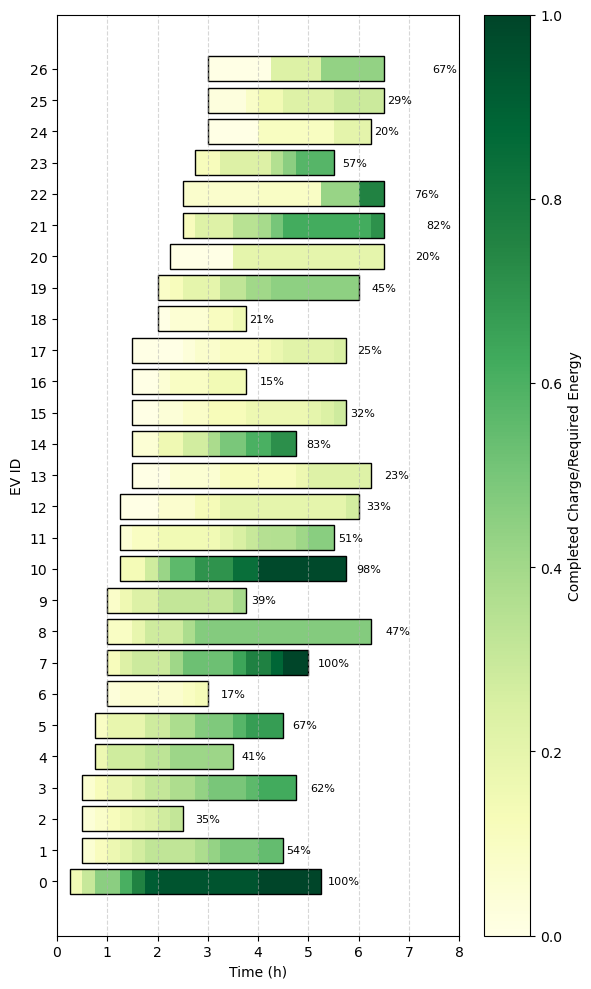

In [28]:
# Plot
fig, ax = plt.subplots(figsize=(6,10))
cmap = cm.get_cmap("YlGn")
norm = Normalize(vmin=0, vmax=1)

# Time Values
time_values = np.array([float(t) for t in charging_prof.columns])

# Loop through each EV
for i, row in charging_prof.iterrows():
    if i<27:
        ev_id = str(i)
        arrival = session_df.loc[i, "arrival_time"]
        departure = session_df.loc[i, "departure_time"]

        # Extract power values as a NumPy array
        powers = row.values

        # Filter time window
        mask = (time_values >= arrival) & (time_values <= departure)
        times = time_values[mask]
        powers = powers[mask]

        # # Normalize power for color (or replace with cumulative energy/efficiency if preferred)
        colors = cmap(norm(powers))

        # Draw segments
        for j in range(len(times) - 1):
            ax.barh(
                y=ev_id,
                width=times[j+1] - times[j],
                left=times[j],
                height=0.8,
                color=colors[j],
                edgecolor="none"
            )
        ax.barh(
            y=ev_id,
            width=times[-1] - times[0],
            left=times[0],
            height=0.8,
            color="none",
            edgecolor="black"
        )
        percent = powers[-1] * 100

        # Add annotation
        ax.text(
            x=departure + 0.05,  # small offset to the right
            y=int(ev_id),
            s=f"{percent:.0f}%",
            va="center",
            ha="left",
            fontsize=8,
            color="black"
        )

ax.set_xlabel("Time (h)")
ax.set_ylabel("EV ID")
# ax.set_title("EV Charging Schedule")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
ax.set_xlim([0,8])
# Step 5: Colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Completed Charge/Required Energy")
plt.tight_layout()
plt.show()